# Project: Strategic Expansion Analysis for Financial Inclusion in Kenya

## The Project Goal:

In many emerging markets, the greatest barrier to economic growth is not a lack of money, but a lack of access.
This project uses data science to solve a critical business and social problem: 

#### Where should a financial institution build its next branches to maximize impact and improve inclusivity?



Instead of guessing or choosing locations based solely on existing cities, this analysis identifies "Financial Deserts"; heavily populated areas where citizens are currently cut off from the formal economy. By using Machine Learning to analyze travel times and population density, we create a data-driven roadmap to bring financial services to the people who need them most.

# Phase 1: Data Acquisition & Environment Setup

In this first phase, I gathered and combined three "layers" of information to create a complete picture of the Kenyan landscape:


The Demand (Populated Places): We used data for over 9,900 cities, towns, and villages. This tells us exactly where the people are and the type of settlement they live in (from major cities to small hamlets).


The Supply (Financial Services): We mapped every known bank branch, ATM, and mobile money agent currently operating in the country. This allows us to see who is already being served and who is being ignored.


The Boundaries (Administrative Regions): We included official county borders to ensure our recommendations are organized by local government regions for easier reporting.


The Source Files:
To ensure this analysis is reproducible and accurate, we used the following specific data files:


1. hotosm_ken_populated_places_points_shp: The primary source for town names and population centers.

2. hotosm_ken_financial_services_points_shp: The detailed log of current financial infrastructure.

3. ken_admin_boundaries.shp: The official administrative map of Kenya’s counties

In [2]:
!pip install geopandas pandas scikit-learn matplotlib seaborn shapely

Defaulting to user installation because normal site-packages is not writeable


In [3]:
import geopandas as gpd
import os

# 1. List the files to see what is actually there
print("Files in the People folder:", os.listdir('hotosm_ken_populated_places_points_shp'))
print("Files in the Finance folder:", os.listdir('hotosm_ken_financial_services_points_shp'))

# 2. Try loading again with the most likely names
# (If your folder names are slightly different, change the text inside the quotes below)
try:
    places_gdf = gpd.read_file('hotosm_ken_populated_places_points_shp/hotosm_ken_populated_places_points.shp')
    finance_gdf = gpd.read_file('hotosm_ken_financial_services_points_shp/hotosm_ken_financial_services_points.shp')
    
    print("\nSuccess! Both files loaded.")
    print(f"Towns found: {len(places_gdf)}")
except Exception as e:
    print("\nStill a path issue. Error message:", e)

Files in the People folder: ['hotosm_ken_populated_places_points_shp.cpg', 'hotosm_ken_populated_places_points_shp.dbf', 'hotosm_ken_populated_places_points_shp.prj', 'hotosm_ken_populated_places_points_shp.shp', 'hotosm_ken_populated_places_points_shp.shx', 'Readme.txt']
Files in the Finance folder: ['hotosm_ken_financial_services_points_shp.cpg', 'hotosm_ken_financial_services_points_shp.dbf', 'hotosm_ken_financial_services_points_shp.prj', 'hotosm_ken_financial_services_points_shp.shp', 'hotosm_ken_financial_services_points_shp.shx', 'Readme.txt']

Still a path issue. Error message: hotosm_ken_populated_places_points_shp/hotosm_ken_populated_places_points.shp: No such file or directory


In [4]:
import geopandas as gpd

print("Attempting to load files with the corrected names...")

# 1. Load the shapefiles using the EXACT names from your folder
places_gdf = gpd.read_file('hotosm_ken_populated_places_points_shp/hotosm_ken_populated_places_points_shp.shp')
finance_gdf = gpd.read_file('hotosm_ken_financial_services_points_shp/hotosm_ken_financial_services_points_shp.shp')

# 2. Success Check
print(f"Success! Found {len(places_gdf)} towns in Kenya.")
print(f"Success! Found {len(finance_gdf)} financial services/agents.")

# 3. Quick peek at the data
print("\nFirst 5 towns identified:")
print(places_gdf[['name', 'place']].head())

Attempting to load files with the corrected names...
Success! Found 9909 towns in Kenya.
Success! Found 1737 financial services/agents.

First 5 towns identified:
              name    place
0         Nachukui  village
1  Spanish Mission  village
2      Nariokotome   hamlet
3         Riokomor  village
4          Nairobi     city


# Phase 2: Geospatial Distance Calculation

Raw GPS coordinates are measured in "degrees," which are not accurate when calculating how far a human has to walk. 
I applied a specific mathematical map projection (EPSG:21037) to flatten the map of Kenya. I chose this because it allowed me to convert those GPS degrees into actual, measurable kilometers. 
Once the map was flat, I calculated exactly how far every single town is from the nearest financial service.


In [5]:
# Re-project to Kenya's coordinate system (Unit = Meters)
places_gdf = places_gdf.to_crs(epsg=21037)
finance_gdf = finance_gdf.to_crs(epsg=21037)

# Check if the CRS is now the Kenyan Projected System (21037)
print(f"Current Map Projection: {places_gdf.crs}")

Current Map Projection: EPSG:21037


# Phase 3.1: Calculating Distance and Identifying Gaps

First, I calculated the exact one-way distance from every single town to the nearest bank or mobile money agent. I applied a math function to measure the distance to all agents, pick the smallest one, and convert the result into kilometers.

(Note: I will fully calculate the actual "Walking Hours" and explain the economic cost of this time in Phase 3.2, but I used the concept of a round-trip walk here to define my tiers).

Next, I grouped these one-way distances into four "Accessibility Tiers" to make the data easy to understand. I chose these specific cutoffs based on the real-world time it takes a human being to walk to-and-fro. ( assuming an average walk speed of 5kmph)

Tier 1: High Access (0-2km)

Tier 2: Moderate Access (2-5km)

Tier 3: Underserved (5-10km)

Tier 4: Critical Desert (>10km)

In [6]:
# 1. THE MATH: Calculate distance from every town to the nearest financial agent
def calculate_min_distance(town_point, agents_gdf):
    # This finds the distance to ALL agents and picks the smallest one
    distances = agents_gdf.distance(town_point)
    return distances.min() / 1000  # Convert meters to Kilometers

print("Calculating distances for 9,909 towns... please wait.")
places_gdf['dist_to_finance_km'] = places_gdf.geometry.apply(lambda x: calculate_min_distance(x, finance_gdf))

# 2. THE INTUITION: Define and apply Accessibility Tiers
def get_tier(dist):
    if dist <= 2: return 'Tier 1: High Access (0-2km)'
    elif dist <= 5: return 'Tier 2: Moderate Access (2-5km)'
    elif dist <= 10: return 'Tier 3: Underserved (5-10km)'
    else: return 'Tier 4: Critical Desert (>10km)'

places_gdf['access_tier'] = places_gdf['dist_to_finance_km'].apply(get_tier)

# 3. THE SUMMARY: Create a table for the final report
tier_summary = places_gdf['access_tier'].value_counts().sort_index().reset_index()
tier_summary.columns = ['Accessibility Tier', 'Town Count']
tier_summary['Percentage (%)'] = (tier_summary['Town Count'] / len(places_gdf) * 100).round(2)

print("\n" + "="*40)
print("   STRATEGIC ACCESSIBILITY BREAKDOWN")
print("="*40)
print(tier_summary.to_string(index=False))
print("="*40)

# 4. PREVIEW: Show the top 5 most isolated towns
print("\nMost Isolated Towns (Top 5):")
print(places_gdf[['name', 'dist_to_finance_km', 'access_tier']].sort_values(by='dist_to_finance_km', ascending=False).head(5))

Calculating distances for 9,909 towns... please wait.

   STRATEGIC ACCESSIBILITY BREAKDOWN
             Accessibility Tier  Town Count  Percentage (%)
    Tier 1: High Access (0-2km)         784            7.91
Tier 2: Moderate Access (2-5km)         891            8.99
   Tier 3: Underserved (5-10km)        1827           18.44
Tier 4: Critical Desert (>10km)        6407           64.66

Most Isolated Towns (Top 5):
            name  dist_to_finance_km                      access_tier
2793     El Yibo          212.962594  Tier 4: Critical Desert (>10km)
3806      Dukana          200.935666  Tier 4: Critical Desert (>10km)
3786     El Hadi          170.469036  Tier 4: Critical Desert (>10km)
29    Yaa Algana          169.540843  Tier 4: Critical Desert (>10km)
3645  Chachabole          162.194581  Tier 4: Critical Desert (>10km)


## Phase 3.2: Administrative Mapping and Walking Hours calculation

First, I brought in the official county boundaries of Kenya and mapped every town to its correct county using a spatial join.

Second, I formally calculated the "Walking Hours." I did this by dividing the one-way distance calculated in Phase 3.1 by an average human walking speed of 5 kilometers per hour.

I chose to create this specific metric because; "12 kilometers away" is far less impactful than proving "a citizen loses almost 2.5 hours just walking there, and another 2.5 hours walking back; this shows the true economic opportunity cost of time.


In [7]:
import geopandas as gpd

print("Loading County Boundaries...")
counties_gdf = gpd.read_file('ken_admin_boundaries.shp/ken_admin1.shp')

# 1. MATCH THE CRS
counties_gdf = counties_gdf.to_crs(epsg=21037)

# 2. Perform the Spatial Join
print("Performing Spatial Join...")
# Updated to extract 'adm1_name' instead of 'ADM1_EN'
places_with_county = gpd.sjoin(places_gdf, counties_gdf[['adm1_name', 'geometry']], how='left', predicate='intersects')

# 3. Clean up the column name
# Updated to rename 'adm1_name' to 'County'
places_with_county = places_with_county.rename(columns={'adm1_name': 'County'})

# 4. Calculate the Economics (Opportunity Cost of Time)
print("Calculating Economic Cost (Walking Hours)...")
places_with_county['walking_hours'] = (places_with_county['dist_to_finance_km'] / 5).round(1)

# --- VALIDATION AND CONFIRMATION PRINTS ---
print("\n" + "="*50)
print("   PHASE 3.5: DATA ENRICHMENT VALIDATION REPORT")
print("="*50)

# Check 1: Did the total number of rows remain consistent?
print(f"Total towns processed: {len(places_with_county)}")

# Check 2: How many towns successfully matched to a county polygon?
missing_counties = places_with_county['County'].isna().sum()
if missing_counties == 0:
    print("County Match Rate: 100% (All towns successfully tagged)")
else:
    print(f"County Match Rate: {len(places_with_county) - missing_counties} tagged, {missing_counties} missing")

# Check 3: Economic Cost Statistics
avg_walk = places_with_county['walking_hours'].mean()
max_walk = places_with_county['walking_hours'].max()
print(f"Average walking time to finance: {avg_walk:.1f} hours")
print(f"Maximum walking time to finance: {max_walk:.1f} hours")
print("="*50)

# Final Visual Check
print("\nData Sample (Top 5 rows):")
print(places_with_county[['name', 'County', 'dist_to_finance_km', 'walking_hours', 'access_tier']].head())

Loading County Boundaries...
Performing Spatial Join...
Calculating Economic Cost (Walking Hours)...

   PHASE 3.5: DATA ENRICHMENT VALIDATION REPORT
Total towns processed: 9909
County Match Rate: 9567 tagged, 342 missing
Average walking time to finance: 4.5 hours
Maximum walking time to finance: 42.6 hours

Data Sample (Top 5 rows):
              name   County  dist_to_finance_km  walking_hours  \
0         Nachukui  Turkana          108.409487           21.7   
1  Spanish Mission  Turkana          113.666327           22.7   
2      Nariokotome  Turkana          114.193270           22.8   
3         Riokomor  Turkana          104.559735           20.9   
4          Nairobi  Nairobi            0.214464            0.0   

                       access_tier  
0  Tier 4: Critical Desert (>10km)  
1  Tier 4: Critical Desert (>10km)  
2  Tier 4: Critical Desert (>10km)  
3  Tier 4: Critical Desert (>10km)  
4      Tier 1: High Access (0-2km)  


In [8]:
# Labeling missing county data as 'Other / Border'
places_with_county['County'] = places_with_county['County'].fillna('Other / Border')

# Professional verification of the fix
print("Data Cleanup: Missing Counties")
print("-" * 30)
unassigned_count = (places_with_county['County'] == 'Other / Border').sum()
print(f"Points labeled as 'Other / Border': {unassigned_count}")
print(f"Top 5 Counties by town count:\n{places_with_county['County'].value_counts().head()}")

Data Cleanup: Missing Counties
------------------------------
Points labeled as 'Other / Border': 342
Top 5 Counties by town count:
County
Nakuru        3391
Kisumu         951
Kilifi         524
Busia          418
Tana River     361
Name: count, dtype: int64


# Phase 4.1 : Calculating Population Weights and The Impact Score

First, I transformed qualitative tags like "City" or "Hamlet" into a measurable scale. I assigned a quantitative "Population Weight" to each location, giving a City 1000 points, a Town 100 points, and a small Hamlet 1 point. I chose this specific Base-10 scale because human populations grow exponentially, and the computer needs to mathematically understand that a city is vastly larger than an isolated settlement.

Second, I calculated the Impact Score. I did this by multiplying the town's Population Weight by its Opportunity Cost of Time (Walking Hours). I chose this calculation because a massive town with a very long walk gets a massive score, instantly proving that it requires urgent intervention.

In [9]:
# --- Phase 4.1: Engineering the Burden ---
import pandas as pd

# 1. Assign a mathematical weight to each settlement size using a Base-10 scale
weight_map = {
    'city': 1000, 
    'town': 100, 
    'village': 10, 
    'hamlet': 1, 
    'isolated_dwelling': 0.1
}

# 2. Map these weights to our main dataset (defaulting to 1 if missing)
places_with_county['pop_weight'] = places_with_county['place'].map(weight_map).fillna(1)

# 3. Calculate the Impact Score: (Population Weight) x (Walking Hours)
places_with_county['impact_score'] = (places_with_county['pop_weight'] * places_with_county['walking_hours']).round(2)

# --- CODE TEST & VALIDATION ---
print("STATUS: Phase 4.1 Complete.")
print("Sample of our newly engineered Weights and Impact Scores:")
print(places_with_county[['name', 'County', 'place', 'pop_weight', 'impact_score']].head(3))

STATUS: Phase 4.1 Complete.
Sample of our newly engineered Weights and Impact Scores:
              name   County    place  pop_weight  impact_score
0         Nachukui  Turkana  village        10.0         217.0
1  Spanish Mission  Turkana  village        10.0         227.0
2      Nariokotome  Turkana   hamlet         1.0          22.8


# Phase 4.2: Creating Readable Population Ranges

I applied clear text labels (like "10k - 100k people") to the different settlement categories. I chose to do this to help ininstantly graspping the human scale of the town without having to guess what a mathematical weight of "100" means.

In [10]:
# --- Phase 4.2: Readable Ranges for Dashboards ---

# 1. Define the human-readable text for each settlement category
range_map = {
    'city': '100k - 5M+ people', 
    'town': '10k - 100k people', 
    'village': '500 - 10k people', 
    'hamlet': '50 - 500 people', 
    'isolated_dwelling': '< 50 people'
}

# 2. Apply this text to a new column to prepare for the final Power BI export
places_with_county['pop_range'] = places_with_county['place'].map(range_map).fillna('Rural Settlement')

# --- CODE TEST & VALIDATION ---
print("STATUS: Phase 4.2 Complete.")
print("Sample of Executive Population Ranges:")
# Included 'County' to verify regional data mapping remains intact
print(places_with_county[['name', 'County', 'place', 'pop_range']].head(5))

STATUS: Phase 4.2 Complete.
Sample of Executive Population Ranges:
              name   County    place          pop_range
0         Nachukui  Turkana  village   500 - 10k people
1  Spanish Mission  Turkana  village   500 - 10k people
2      Nariokotome  Turkana   hamlet    50 - 500 people
3         Riokomor  Turkana  village   500 - 10k people
4          Nairobi  Nairobi     city  100k - 5M+ people


# Phase 4.3: Finding the Perfect Number of Hubs(Clusters) using The Elbow Method

Next, I used a Machine Learning strategy to find the rank of the best locations for new financial hubs.

Before deciding where to build new financial hubs, my model needs to mathematically determine exactly how many we should build. To set up this Machine Learning strategy, I used a two-step approach:

Step 1: The Filter. Instead of evaluating every town, I used the Impact Score to isolate only the Top 15% of the country where the economic burden is the most severe. This ensures the model completely ignores already well-served cities like Nairobi.

Step 2: The Magnets. I used the Population Weights calculated in Phase 4.1. In a standard analysis, every town has the exact same "pull." In my model, a town with 50,000 people acts as a much stronger magnet than a village of 50. This forces the algorithm to pull the new hubs away from empty areas and directly toward the largest concentrations of struggling citizens.



How the Model Finds the "Sweet Spot" (The Math):

To find the optimal number of hubs, the model uses the Elbow Method. It tests different network sizes in increments of 5 (10 hubs, 15 hubs, 20 hubs... all the way to 300). To completely eliminate human guesswork, the model uses a geometric formula to pinpoint the exact optimal number:

The Straight Baseline: The model draws an invisible, perfectly straight line connecting the very first test (10 hubs) directly to the final test (300 hubs).

The Vertical Drop: Because the actual data drops rapidly before flattening out, it forms a curve that dips deep underneath that straight baseline. The model drops a vertical line from the straight baseline down to the curve at every single test point to measure the gap.

The Sweet Spot: The specific number of hubs where this vertical line is the longest is the exact apex of the bend. This point of maximum distance represents the absolute maximum coverage achieved before the expansion begins wasting money on diminishing returns

Running simulations in steps of 5 to find the exact curve...

[MATHEMATICAL OPTIMUM] The algorithm found the sweet spot at exactly 50 hubs.

--- PROOF OF OPTIMALITY ---
Distance from baseline (Higher is better, showing the sharpest bend):
                 k=25  | Deviation Distance: 190.54
                 k=30  | Deviation Distance: 202.79
                 k=35  | Deviation Distance: 212.37
                 k=40  | Deviation Distance: 215.45
                 k=45  | Deviation Distance: 217.39
--> [SWEET SPOT] k=50  | Deviation Distance: 218.59
                 k=55  | Deviation Distance: 218.31
                 k=60  | Deviation Distance: 216.61
                 k=65  | Deviation Distance: 215.10
                 k=70  | Deviation Distance: 212.06
                 k=75  | Deviation Distance: 208.79

--- 4 STRATEGIC EXPANSION SCENARIOS ---
 - Tier 1 (Pilot Testing): 25 Hubs
 - Tier 2 (Conservative / Optimal): 50 Hubs
 - Tier 3 (Aggressive): 75 Hubs
 - Tier 4 (Maximum Penetration): 100 

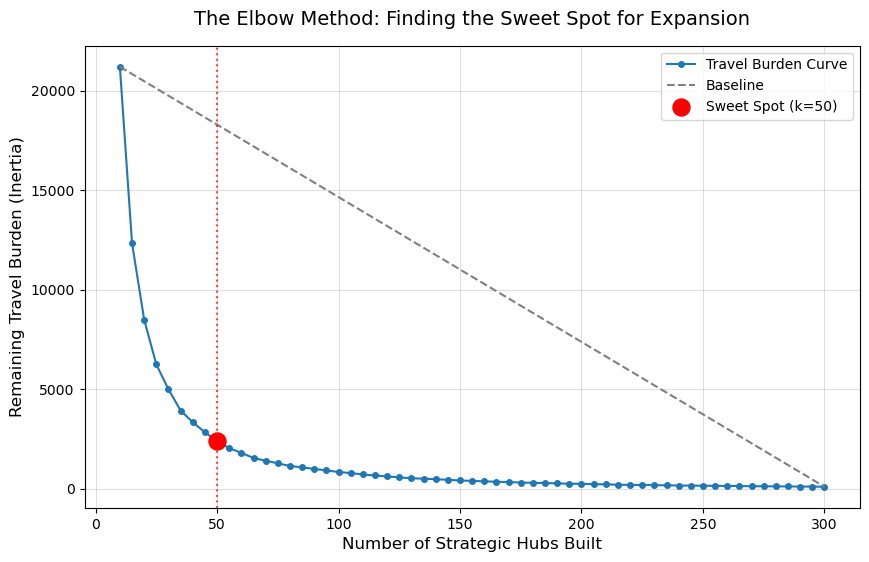


STATUS: Phase 4.3 Complete. Moving to Phase 4.4 to deploy K-Means clustering.


In [11]:
# # --- Phase 4.3: The Elbow Method (Finding the Sweet Spot) ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# 1. THE FILTER: Select only the Top 15% most burdened towns
impact_threshold = places_with_county['impact_score'].quantile(0.85)
critical_zones = places_with_county[places_with_county['impact_score'] >= impact_threshold].copy()

# 2. THE MAGNETS: Extract coordinates and Population Weights
critical_zones_gps = critical_zones.to_crs(epsg=4326)
coords = critical_zones_gps.geometry.apply(lambda p: [p.y, p.x]).tolist()
pop_weights = critical_zones['pop_weight'].tolist()

# 3. RUN THE TESTS: Check networks from 10 to 300 hubs in increments of 5
k_values = list(range(10, 301, 5))
travel_burden = []

print("Running simulations in steps of 5 to find the exact curve...")
for k in k_values:
    model = KMeans(n_clusters=k, n_init=10, random_state=42).fit(coords, sample_weight=pop_weights)
    travel_burden.append(model.inertia_)

# 4. THE MATH: Automatically calculate the exact "Sweet Spot" 
x1, y1 = k_values[0], travel_burden[0]
x2, y2 = k_values[-1], travel_burden[-1]

distances = []
for i in range(len(k_values)):
    x0, y0 = k_values[i], travel_burden[i]
    # Geometric distance formula from the curve to the straight baseline
    numerator = abs((y2 - y1) * x0 - (x2 - x1) * y0 + x2 * y1 - y2 * x1)
    denominator = np.sqrt((y2 - y1)**2 + (x2 - x1)**2)
    distances.append(numerator / denominator)

optimal_index = np.argmax(distances)
sweet_spot_k = k_values[optimal_index]

# 5. PROOF OF OPTIMALITY: Display surrounding points
print(f"\n[MATHEMATICAL OPTIMUM] The algorithm found the sweet spot at exactly {sweet_spot_k} hubs.")
print("\n--- PROOF OF OPTIMALITY ---")
print("Distance from baseline (Higher is better, showing the sharpest bend):")

# Get the 5 points below and 5 points above the sweet spot safely
start_idx = max(0, optimal_index - 5)
end_idx = min(len(k_values), optimal_index + 6)

for i in range(start_idx, end_idx):
    marker = "--> [SWEET SPOT] " if i == optimal_index else "                 "
    print(f"{marker}k={k_values[i]:<3} | Deviation Distance: {distances[i]:.2f}")

# 6. STRATEGY: Generate the 4 Budget Tiers based on the Math
strategic_tiers = {
    "Tier 1 (Pilot Testing)": max(10, int(sweet_spot_k * 0.5)),
    "Tier 2 (Conservative / Optimal)": sweet_spot_k,
    "Tier 3 (Aggressive)": int(sweet_spot_k * 1.5),
    "Tier 4 (Maximum Penetration)": int(sweet_spot_k * 2.0)
}

print("\n--- 4 STRATEGIC EXPANSION SCENARIOS ---")
for tier, hubs in strategic_tiers.items():
    print(f" - {tier}: {hubs} Hubs")

# 7. VISUALIZATION: Plotting the Elbow Curve
plt.figure(figsize=(10, 6))
plt.plot(k_values, travel_burden, marker='o', markersize=4, linestyle='-', color='#1f77b4', label='Travel Burden Curve')
plt.plot([x1, x2], [y1, y2], linestyle='--', color='gray', label='Baseline')

# Highlight the mathematical optimum
plt.scatter(sweet_spot_k, travel_burden[optimal_index], color='red', s=150, zorder=5, label=f'Sweet Spot (k={sweet_spot_k})')
plt.axvline(x=sweet_spot_k, color='red', linestyle=':', alpha=0.7)

plt.title('The Elbow Method: Finding the Sweet Spot for Expansion', fontsize=14, pad=15)
plt.xlabel('Number of Strategic Hubs Built', fontsize=12)
plt.ylabel('Remaining Travel Burden (Inertia)', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.4)
plt.show()

print("\nSTATUS: Phase 4.3 Complete. Moving to Phase 4.4 to deploy K-Means clustering.")

# Phase 4.4 Mapping and Ranking the 50 Base Camps

To turn our optimal network size into actual coordinates on a map, my model deployed a K-Means Clustering algorithm set to exactly 50 hubs. The algorithm performed the final calculations to find the exact "center points" where a single new branch can serve the maximum number of people possible.

I then matched these mathematical coordinates to the nearest real-world Kenyan towns. These 50 towns serve as our strategic "Base Camps."

Finally, to provide an actionable rollout strategy, I sorted these 50 Base Camps strictly by their Impact Scores (from highest to lowest). This creates a definitive National Hub Leaderboard. If the budget is constrained ; for example to just 5 new branches, they can simply execute ranks #1 through #5. This ensures the limited capital is spent in the areas of most severe economic need first.

In [16]:
# --- Phase 4.4: Deploying K-Means & Ranking the Base Camps ---
from scipy.spatial import cKDTree
import pandas as pd
from sklearn.cluster import KMeans

# 1. THE MATH: Calculate the exact geographic center points for the 50 Hubs
# (This math happens in meters because 'coords' is in EPSG:21037)
final_model = KMeans(n_clusters=sweet_spot_k, n_init=10, random_state=42).fit(coords, sample_weight=pop_weights)
math_centers = final_model.cluster_centers_

# 2. THE MATCHING: Map the math points to the nearest real towns
# We build the search tree while the map is still in meters to match the math_centers
tree = cKDTree(list(zip(critical_zones_gps.geometry.y, critical_zones_gps.geometry.x)))

# --- CRITICAL FIX: Reproject back to standard GPS (Degrees) so Power BI can read it ---
critical_zones_gps = critical_zones_gps.to_crs(epsg=4326)

base_camp_list = []

for i, center in enumerate(math_centers):
    # Query the tree using the math centers (Meters)
    dist, idx = tree.query([center[0], center[1]])
    
    # Extract the REAL town data (Which is now back in standard GPS Degrees)
    town = critical_zones_gps.iloc[idx]
    
    base_camp_list.append({
        'Strategic_Base_Camp': town['name'],
        'County': town['County'],
        'Pop_Range': town['pop_range'],
        'Impact_Score': town['impact_score'],
        'Strategic_Town_Latitude': town.geometry.y,   # Real town location
        'Strategic_Town_Longitude': town.geometry.x   # Real town location
    })

# Convert to a clean DataFrame
hubs_df = pd.DataFrame(base_camp_list)

# 3. THE RANKING: Sort the 50 Hubs by Impact Score (Highest to Lowest)
ranked_hubs = hubs_df.sort_values(by='Impact_Score', ascending=False).copy()

# Assign the official National Rank (1 through 50)
ranked_hubs['National_Hub_Rank'] = range(1, len(ranked_hubs) + 1)

# Reorder columns for a clean executive view
final_cols = ['National_Hub_Rank', 'Strategic_Base_Camp', 'County', 'Pop_Range', 
              'Impact_Score', 'Strategic_Town_Latitude', 'Strategic_Town_Longitude']
final_hub_leaderboard = ranked_hubs[final_cols]

# --- OUTPUT THE OFFICIAL RANKED LIST ---
print("\nSTATUS: Phase 4.4 Complete. 50 Base Camps identified and ranked.")
print("\n--- OFFICIAL NATIONAL HUB LEADERBOARD (TOP 10) ---")
print(final_hub_leaderboard.head(10).to_string(index=False))


STATUS: Phase 4.4 Complete. 50 Base Camps identified and ranked.

--- OFFICIAL NATIONAL HUB LEADERBOARD (TOP 10) ---
 National_Hub_Rank Strategic_Base_Camp          County         Pop_Range  Impact_Score  Strategic_Town_Latitude  Strategic_Town_Longitude
                 1        Loiyangalani        Marsabit 10k - 100k people        2610.0                 2.757680                 36.718658
                 2              Kutulo           Wajir 10k - 100k people        1850.0                 2.407899                 40.594821
                 3             Baragoi         Samburu 10k - 100k people        1530.0                 1.783300                 36.783300
                 4         Ibrahim Ure           Wajir 10k - 100k people        1240.0                 1.579325                 40.613298
                 5             Kalokol         Turkana 10k - 100k people        1060.0                 3.532742                 35.857023
                 6             Lorugum         Turkana

# Phase 4.5: Creating the National Coverage Map
p
In Phase 4.4, we identified the 50 best locations for our new branches (The Hubs). However, we still have hundreds of other high-impact towns that need financial services (The Spokes).

In this final stage, my code connects every single struggling town to its nearest ranked Base Camp. It creates a "Hub and Spoke" system, ensuring that no community is left behind in the planning process.

The code does this by looking at the algorithm's memory from the previous step, taking the Master List of all high-impact towns, and tagging each town with its assigned Regional Hub..

In [17]:
# --- Phase 4.5: Network Mapping (Hub & Spoke Connections) ---

# 1. PULL FROM MEMORY: Get the cluster ID assigned to each town during Phase 4.4
# (final_model.labels_ holds the ID numbers for each town)
critical_zones_gps['Cluster_ID'] = final_model.labels_

# 2. CREATE DICTIONARIES: Map the ID numbers to the official Rank and Name
hub_rank_map = ranked_hubs['National_Hub_Rank'].to_dict()
hub_name_map = ranked_hubs['Strategic_Base_Camp'].to_dict()

# 3. TAG THE TOWNS: Link every town to its official Hub Rank and Name
critical_zones_gps['Assigned_Hub_Rank'] = critical_zones_gps['Cluster_ID'].map(hub_rank_map)
critical_zones_gps['Assigned_Hub_Name'] = critical_zones_gps['Cluster_ID'].map(hub_name_map)

# --- QUALITY CONTROL ---
total_towns = len(critical_zones_gps)
mapped_towns = critical_zones_gps['Assigned_Hub_Rank'].notna().sum()

print("STATUS: Phase 4.5 Complete. Network Mapping finished.\n")
print(f"Audit: {mapped_towns} out of {total_towns} high-impact towns successfully linked to a Hub.")

# Show a quick sample of the new columns
print("\n--- SAMPLE: SPOKES ASSIGNED TO HUB #1 ---")
sample_cols = ['name', 'County', 'impact_score', 'Assigned_Hub_Rank', 'Assigned_Hub_Name']
print(critical_zones_gps[critical_zones_gps['Assigned_Hub_Rank'] == 1][sample_cols].head(5).to_string(index=False))

STATUS: Phase 4.5 Complete. Network Mapping finished.

Audit: 1519 out of 1519 high-impact towns successfully linked to a Hub.

--- SAMPLE: SPOKES ASSIGNED TO HUB #1 ---
            name   County  impact_score  Assigned_Hub_Rank Assigned_Hub_Name
Elelekerio Lowue  Turkana         150.0                  1      Loiyangalani
        Nakuriot  Turkana         136.0                  1      Loiyangalani
         Olturot Marsabit         210.0                  1      Loiyangalani
             Gas Marsabit         273.0                  1      Loiyangalani
     Kang'irisai  Turkana         184.0                  1      Loiyangalani


# Phase 5: Final Data Preparation & Exporting to Power BI

To finish our project, we are organizing our results into three specialized files. This allows Power BI to run quickly and allows users to interact with the map seamlessly.

1. The GPS "Fix" (Why we manipulated the coordinates)
Before saving our files, we had to perform a crucial technical step. In Phase 2, we converted our map into a "Projected" system (measured in meters) so our distance and walking-hour calculations would be mathematically accurate.

However, Power BI only understands standard GPS Latitude and Longitude (measured in degrees). In this step, we "unpacked" those complex map shapes back into simple decimal numbers so Power BI knows exactly where to place every town on the globe.

2. Our Final 3 CSV Files
Instead of one giant spreadsheet, we are exporting a professional "Star Schema" model:


CSV 1: The Master Town Data –  It contains every town in Kenya with its urgency score and population. 


CSV 2: The Strategic Hubs (Leaderboard) – It contains only our 50 Base Camps, ranked from 1 to 50 based on which locations will have the highest national impact.


CSV 3: The Hub & Spoke Network – This is the most detailed file. It lists the 1,500+ struggling towns and explicitly links each one to its assigned Hub. These are ranked by their Assigned Hub Number, which allows you to click on a Hub in Power BI and instantly see all the towns it serves.


In [19]:
# --- Phase 5: Data Extraction & Power BI Export ---
import pandas as pd

# 1. RESCUE WALKING HOURS (Safety check to ensure no data is left behind)
if 'walking_hours' not in places_with_county.columns and 'places_with_dist' in locals():
    print("Rescuing 'walking_hours' from Phase 2...")
    places_with_county = places_with_county.merge(
        places_with_dist[['name', 'walking_hours']], 
        on='name', 
        how='left'
    )

# 2. THE GPS FIX: Unpacking geometry back into standard Degrees (Latitude/Longitude)
# Convert the master list and the spokes back to standard GPS degrees (EPSG:4326)
places_with_county = places_with_county.to_crs(epsg=4326)
critical_zones_gps = critical_zones_gps.to_crs(epsg=4326)

# Extract the decimal coordinates for Power BI mapping
places_with_county['Town_Longitude'] = places_with_county.geometry.x
places_with_county['Town_Latitude'] = places_with_county.geometry.y

critical_zones_gps['Town_Longitude'] = critical_zones_gps.geometry.x
critical_zones_gps['Town_Latitude'] = critical_zones_gps.geometry.y

# 3. EXPORT THE 3 CSVs
print("Generating final 3 CSV files for Power BI...\n")

# CSV 1: The Master Town Data (Foundation)
# ---> CORRECTED: Added 'access_tier' and 'dist_to_finance_km' <---
cols_1 = ['name', 'County', 'pop_range', 'impact_score', 'access_tier', 'dist_to_finance_km', 'Town_Latitude', 'Town_Longitude']

# Safely append walking_hours if it exists
if 'walking_hours' in places_with_county.columns:
    cols_1.append('walking_hours')
    
places_with_county[cols_1].to_csv('1_Kenya_Master_Town_Data.csv', index=False)
print("-> 1_Kenya_Master_Town_Data.csv created. (Now includes Access Tiers & Km!)")

# CSV 2: The Strategic Hubs (Leaderboard)
# Uses 'Strategic_Town_Latitude/Longitude' built in Phase 4.4
ranked_hubs.to_csv('2_Strategic_Hubs_Leaderboard.csv', index=False)
print("-> 2_Strategic_Hubs_Leaderboard.csv created.")

# CSV 3: The Hub & Spoke Network (Connections)
# Ranked by Assigned_Hub_Rank to group spokes together by their Hub
cols_3 = ['name', 'County', 'Town_Latitude', 'Town_Longitude', 'impact_score', 'Assigned_Hub_Rank', 'Assigned_Hub_Name']
critical_zones_gps[cols_3].sort_values(by='Assigned_Hub_Rank').to_csv('3_Hub_and_Spoke_Network.csv', index=False)
print("-> 3_Hub_and_Spoke_Network.csv created.\n")

print("=========================================================")
print("SUCCESS: Python Pipeline Complete! ")
print("=========================================================")

Generating final 3 CSV files for Power BI...

-> 1_Kenya_Master_Town_Data.csv created. (Now includes Access Tiers & Km!)
-> 2_Strategic_Hubs_Leaderboard.csv created.
-> 3_Hub_and_Spoke_Network.csv created.

SUCCESS: Python Pipeline Complete! 
